In [1]:
import numpy as np 
import math
from itertools import product
import matplotlib.pyplot as plt
plt.style.use('default')

from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import CplexOptimizer
from qiskit.primitives import Sampler, BackendSampler
from qiskit import Aer, QuantumRegister
from qiskit.circuit import QuantumCircuit

from os.path import dirname, abspath
import sys
parent_dir = dirname(dirname(abspath(' ')))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from src.optimizer.Quantum_Optimizer_FGSR_b import *
from src.encode.encode_permutation import *
from src.bitflip_strategy.local_search_general import *

import warnings
warnings.simplefilter('ignore')

In [2]:
pb_num = 7

input_data = open(parent_dir + f'/instances/QAP/tai{pb_num}a.dat', 'r')

Mat_data = []
for j, rows in enumerate(input_data):
    if len(rows) == 1: continue
    if j == 0:
        v = rows.rstrip('\n').split(' ')
        n_size = int(v[0])
        ref_val = int(v[1])
    else:
        d_list = rows.rstrip('\n').split(' ')
        for d in d_list:
            if len(d) == 0: continue
            Mat_data.append(int(d))

input_data.close()

Mat_data = np.asarray(Mat_data, dtype=int).reshape(-1,n_size)
F = Mat_data[:n_size]
D = Mat_data[n_size:]
        
mdl = QuadraticProgram('QAP')

for i,j in product(range(n_size), range(n_size)):
    mdl.binary_var(name=f'x({i},{j})')

mdl.minimize(
    quadratic={(f'x({i},{j})', f'x({k},{l})'):F[i,k]*D[j,l] for i,j,k,l in product(range(n_size),range(n_size),range(n_size),range(n_size))},
)

for i in range(n_size):
    mdl.linear_constraint(linear={f'x({i},{j})':1 for j in range(n_size)}, sense='==', rhs=1)

for i in range(n_size):
    mdl.linear_constraint(linear={f'x({j},{i})':1 for j in range(n_size)}, sense='==', rhs=1)

#print(mdl.prettyprint())

In [3]:
num_qubits = math.ceil(np.log2(math.factorial(n_size)))

print(f'number of system qubits: {num_qubits}')

number of system qubits: 13


In [4]:
efficient_encode = create_encode()
efficient_encode.set_encode(n_size)
decode = efficient_encode.decode

In [5]:
Q_obj = csr_array(mdl.objective.quadratic.to_array())

def objective(x):
    x = decode(x)
    val = x @ Q_obj @ x
    return val

In [6]:
# max number of random flips for each bitstring
n_flips = num_qubits

def search(x):
    x = local_search(x, func=objective, maxiter=n_flips)
    return x

In [7]:
n_reps = 3

q = QuantumRegister(num_qubits, name='q')
sub_qc = QuantumCircuit(q)
qc_params = ParameterVector(name='theta', length=num_qubits*n_reps)

for l in range(n_reps):
    k = 0
    while 2*k < num_qubits-1:
        sub_qc.cz(q[2*k], q[2*k+1])
        k += 1
            
    k = 0
    while 2*k+1 < num_qubits-1:
        sub_qc.cz(q[2*k+1], q[2*k+2])
        k += 1

    for k in range(num_qubits):
        sub_qc.ry(qc_params[l*num_qubits+k], q[k])

    sub_qc.barrier()

In [8]:
shots = 2**10
backend = Aer.get_backend('aer_simulator_matrix_product_state')

sampler = BackendSampler(backend=backend)
sampler.set_options(shots=shots)

print(f'shots = {shots}')

shots = 1024


In [9]:
# configure
alpha = 0.4
max_epoch = 1
restart_s = 0.7
restart_std = 0

In [10]:
cplex_result = CplexOptimizer().solve(mdl)
cplex_optval = cplex_result.fval
refval = cplex_optval

print(refval)

53976.0


In [11]:
QuantumSolver = QuantumOptimizer()
QuantumSolver.set_optimizer(num_qubits, sub_qc, sampler)

QuantumSolver.run(
    objective = objective,
    search = search,
    alpha = alpha,
    random_update = True,
    max_epoch = max_epoch,
    restart_s = restart_s,
    restart_std = restart_std,
    refval = refval,
    intermediate_result_display = True
    )

epoch = 0 	 step = 0 	 objval = 55706.000 	 cvar = 75323.712   	 s-prob = 0.000e+00
epoch = 0 	 step = 0 	 objval = 53976.000 	 cvar = 66398.410   	 s-prob = 1.406e-01
epoch = 0 	 step = 1 	 objval = 53976.000 	 cvar = 65690.756   	 s-prob = 1.533e-01
epoch = 0 	 step = 2 	 objval = 53976.000 	 cvar = 63965.556   	 s-prob = 1.777e-01
epoch = 0 	 step = 3 	 objval = 53976.000 	 cvar = 61374.390   	 s-prob = 2.256e-01
epoch = 0 	 step = 4 	 objval = 53976.000 	 cvar = 61347.829   	 s-prob = 2.285e-01
epoch = 0 	 step = 5 	 objval = 53976.000 	 cvar = 60819.902   	 s-prob = 2.412e-01
epoch = 0 	 step = 6 	 objval = 53976.000 	 cvar = 59872.727   	 s-prob = 2.568e-01
epoch = 0 	 step = 7 	 objval = 53976.000 	 cvar = 56175.512   	 s-prob = 3.418e-01
epoch = 0 	 step = 8 	 objval = 53976.000 	 cvar = 53976.000   	 s-prob = 4.102e-01
epoch = 0 	 step = 9 	 objval = 53976.000 	 cvar = 53976.000   	 s-prob = 4.492e-01
epoch = 0 	 step = 10 	 objval = 53976.000 	 cvar = 53976.000   	 s-prob = 5

In [12]:
result = QuantumSolver.elog

L1 = [3*i+1 for i in range(len(result))]
L2 = list(result)
L3 = list(QuantumSolver.plog)
L4 = list(QuantumSolver.log)

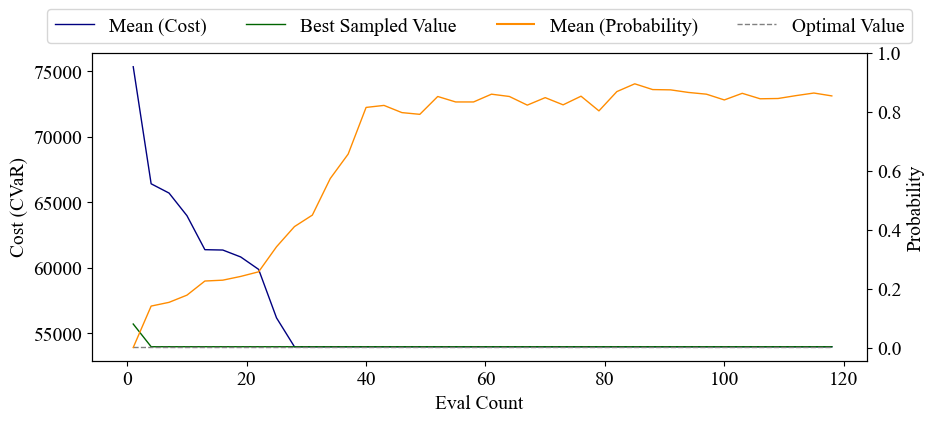

In [13]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.default'] = 'it'

fig, ax = plt.subplots(figsize=(10, 4))
ax2 = ax.twinx()

ax.plot(L1, L2, color='navy', linewidth=1, label='Mean (Cost)')
ax.plot(L1, L4, color='darkgreen', linewidth=1, label='Best Sampled Value')

ax.set_ylabel('Cost (CVaR)')
ax.set_xlabel('Eval Count')

ax.hlines(refval, xmin=0, xmax=0, color='darkorange', label='Mean (Probability)')
ax.hlines(refval, xmin=1, xmax=L1[-1], color='grey', linestyle='dashed', linewidth=1, label='Optimal Value')
ax.legend(loc='lower center', bbox_to_anchor=(.5, 1.0), ncol=4)

ax2.plot(L1, L3, color='darkorange', linewidth=1)
ax2.set_ylabel('Probability')
ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

plt.show()